# Packages 

In [4]:
# Packages Used

import pandas as pd 
import numpy as np

# Models

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.svm import LinearSVR
from sklearn.tree import DecisionTreeRegressor

# Encoding

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# SelectKBest

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import *
from matplotlib import pyplot

# Train Test Split 

from sklearn.model_selection import train_test_split


from scipy.stats import chi2_contingency
from scipy.stats import chi2
from collections import Counter

from sklearn.preprocessing import normalize
from sklearn import preprocessing
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

import statsmodels.formula.api as smf
from sklearn import metrics

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression

from sklearn.preprocessing import StandardScaler

# allow plots to appear directly in the notebook
%matplotlib inline

%matplotlib inline
pd.set_option('display.max_columns', None)

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option("display.max_rows", None, "display.max_columns", None)

pd.options.display.max_rows


# Overview of Data

In [5]:
# Import data and have take a quick look of the data

data_ori = pd.read_csv("hdb1720.csv")

print('Data Shapes:' , data_ori.shape)
print()
print('Data Column Dtypes:')
print(data_ori.dtypes)

data_ori.head()

Data Shapes: (101651, 11)

Data Column Dtypes:
month                   object
town                    object
flat_type               object
block                   object
street_name             object
storey_range            object
floor_area_sqm         float64
flat_model              object
lease_commence_date      int64
remaining_lease         object
resale_price           float64
dtype: object


,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price
0,2017-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,61 years 04 months,232000.0
1,2017-01,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.0,New Generation,1978,60 years 07 months,250000.0
2,2017-01,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,262000.0
3,2017-01,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,04 TO 06,68.0,New Generation,1980,62 years 01 month,265000.0
4,2017-01,ANG MO KIO,3 ROOM,601,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,265000.0


# Check the number of Nan

In [6]:
data_ori.isna().sum() # No nan in each column 

month                  0
town                   0
flat_type              0
block                  0
street_name            0
storey_range           0
floor_area_sqm         0
flat_model             0
lease_commence_date    0
remaining_lease        0
resale_price           0
dtype: int64

In [7]:
data_ori = data_ori.drop(['lease_commence_date','town'], axis=1)

# Functions Built

In [8]:
def feature_selection(data, testsize, method, k):
    
    # Form X and y 

    X = data.drop('resale_price', axis=1)
    y = data['resale_price']
    
    # Perform train test split

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testsize, random_state=1)
    
    # Categorize columns according to requirements

    Enco_ordinal = list(data_ori.dtypes[data_ori.dtypes == object].index)
    Enco_OneHot = []

    # Create a pipeline to perform Encoding use

    pipeline = ColumnTransformer([
    ("o", OrdinalEncoder(), Enco_ordinal),
    ("n", OneHotEncoder(), Enco_OneHot),], remainder='passthrough')

    # Perform Encoding

    X_train_enc = pipeline.fit_transform(X_train)
    X_test_enc = pipeline.fit_transform(X_test)

    # Perform SelectKBest

    fs = SelectKBest(score_func=f_regression, k=k)
    fs.fit(X_train_enc, y_train)

    
    # Get resulted feature names
    
    data_tem = data.copy()
    data_tem = data.drop('resale_price',axis=1)
    column_names = data_tem.columns[fs.get_support()]
    return column_names


# Encoding Selection 

def enc_ord(fil_col):
    
    enc_ord = []
    Enco_ordinal = ["month","flat_type","storey_range"]

    for i in range(len(fil_col)):
            if fil_col[i] in Enco_ordinal:
                enc_ord.append(fil_col[i])
            else:
                continue
                
    return enc_ord

def enc_One(fil_col):
    
    enc_One = []
    Enco_OneHot = ["town", "block","flat_model","street_name","remaining_lease"]

    for i in range(len(fil_col)):
            if fil_col[i] in Enco_OneHot:
                enc_One.append(fil_col[i])
            else:
                continue
                
    return enc_One


# Formulate new dataset 

def filtered_data(data,fil_col):
    data = data_ori.copy()
    data = data[fil_col]
    return data


# Chi2 Test 

def Chi2_allBT_Unwanted(data):
    
    # Create a list with all column names

    correlation_test = data.columns.tolist()
    
    
    # Find the p value of dependency between redundancy with each column

    corr_dic = {}

    for i in range(len(correlation_test)):

            table_test = pd.crosstab(data['resale_price'],data[correlation_test[i]])

            stat, p, dof, expected = chi2_contingency(table_test)

            corr_dic[correlation_test[i]] = np.around(p,4)
            
            
    # Locate wanted and unwanted columns

    corr_dic_wanted = dict()
    corr_dic_unwanted = dict()

    for (key, value) in corr_dic.items():
        if value <= 0.1:
           corr_dic_wanted[key] = value
        elif value >= 0.8:
           corr_dic_unwanted[key] = value
        else:
            continue
        
    return corr_dic_unwanted


def Chi2_allBT_Wanted(data):
    
    # Create a list with all column names

    correlation_test = data.columns.tolist()
    
    
    # Find the p value of dependency between redundancy with each column

    corr_dic = {}

    for i in range(len(correlation_test)):

            table_test = pd.crosstab(data['resale_price'],data[correlation_test[i]])

            stat, p, dof, expected = chi2_contingency(table_test)

            corr_dic[correlation_test[i]] = np.around(p,4)
            
            
    # Locate wanted and unwanted columns

    corr_dic_wanted = dict()
    corr_dic_unwanted = dict()

    for (key, value) in corr_dic.items():
        if value <= 0.1:
           corr_dic_wanted[key] = value
        elif value >= 0.8:
           corr_dic_unwanted[key] = value
        else:
            continue
        
    return corr_dic_wanted

# Featurte Selection base on LR

In [9]:
num = [3,4,5,6,7,8]

for i in range(len(num)):
    
    # Feature Selection
    
    fil_col = feature_selection(data_ori, 0.3, f_regression, num[i])
    fil_col = fil_col.tolist()
    fil_col.append('resale_price')
    print(fil_col)
    
    # Identify all columns that require Encoding

    data = filtered_data(data_ori,fil_col)      
        
    # Categorize columns according to requirements

    Enco_ordinal = enc_ord(fil_col)
    Enco_OneHot = enc_One(fil_col)

    # Create a pipeline to perform Encoding use

    pipeline = ColumnTransformer([
    ("o", OrdinalEncoder(), Enco_ordinal),
    ("n", OneHotEncoder(), Enco_OneHot),], remainder='passthrough')

    # Set X and y for later prediction use

    X = pipeline.fit_transform(data.drop("resale_price", axis=1))
    y = data["resale_price"].values

    # Import train_test_split function
    from sklearn.model_selection import train_test_split

    # Split dataset into training set and test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=1)    
    
    import time
    start = time.process_time()

    # Perform linear regression:

    lr = LinearRegression()
    lr.fit(X_train, y_train)

    print(round((time.process_time() - start)/60 ,2) , 'minutes')
    
    yhat = lr.predict(X_test)

    mae = metrics.mean_absolute_error(y_test, yhat)
    mse = metrics.mean_squared_error(y_test, yhat)
    rmse = np.sqrt(mse)  
    r2 = metrics.r2_score(y_test,yhat)
    Adj_r2 = 1 - (1-r2) * (len(y)-1)/(len(y)-X.shape[1]-1)

    print("Number of Columns used:" , num[i])
    #print("Results of sklearn.metrics:")
    print("MAE:",round(mae,4))
    print("MSE:", round(mse,4))
    print("RMSE:", round(rmse,4))
    print("R-Squared:", round(r2,4))
    print("Adjusted R-Squared:", round(Adj_r2,4))
    print(lr.predict(X_test)[0])



['flat_type', 'storey_range', 'remaining_lease', 'resale_price']


LinearRegression()

0.01 minutes
Number of Columns used: 3
MAE: 72970.4513
MSE: 9992149829.0553
RMSE: 99960.7414
R-Squared: 0.5909
Adjusted R-Squared: 0.5883
678424.0114607636
['flat_type', 'storey_range', 'flat_model', 'remaining_lease', 'resale_price']


LinearRegression()

0.02 minutes
Number of Columns used: 4
MAE: 68756.0843
MSE: 8770386894.8521
RMSE: 93650.3438
R-Squared: 0.6409
Adjusted R-Squared: 0.6386
662268.2099534748
['flat_type', 'storey_range', 'floor_area_sqm', 'flat_model', 'remaining_lease', 'resale_price']


LinearRegression()

0.01 minutes
Number of Columns used: 5
MAE: 67494.1181
MSE: 8538269605.477
RMSE: 92402.7576
R-Squared: 0.6504
Adjusted R-Squared: 0.6481
783696.6898069454
['month', 'flat_type', 'storey_range', 'floor_area_sqm', 'flat_model', 'remaining_lease', 'resale_price']


LinearRegression()

0.02 minutes
Number of Columns used: 6
MAE: 67385.5118
MSE: 8477503142.7866
RMSE: 92073.3574
R-Squared: 0.6529
Adjusted R-Squared: 0.6506
790935.710425653
['month', 'flat_type', 'street_name', 'storey_range', 'floor_area_sqm', 'flat_model', 'remaining_lease', 'resale_price']


LinearRegression()

0.03 minutes
Number of Columns used: 7
MAE: 31543.0248
MSE: 1753637557.3375
RMSE: 41876.4559
R-Squared: 0.9282
Adjusted R-Squared: 0.9273
743521.7400065896
['month', 'flat_type', 'block', 'street_name', 'storey_range', 'floor_area_sqm', 'flat_model', 'remaining_lease', 'resale_price']


LinearRegression()

0.03 minutes
Number of Columns used: 8
MAE: 28869.0322
MSE: 1489107416.9
RMSE: 38588.9546
R-Squared: 0.939
Adjusted R-Squared: 0.9367
776775.046766289


In [10]:
X_test.toarray()[0]

array([ 29.,   5.,   3., ...,   0.,   0., 189.])

# Cross Validation - Linear Regression 

In [11]:
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score, LeaveOneOut,\
RepeatedKFold, train_test_split

def cv(data,model,fil_col,n_splits):
    
    # Create a data copy

    data_cv = data_ori.copy()
    
    # Prepare Encoding and Normalizing

    Enco_ordinal = enc_ord(fil_col)
    Enco_OneHot = enc_One(fil_col)
    num_cols = data_cv.select_dtypes('float64','int64').columns.tolist()
    num_cols.remove('resale_price')

    ct = ColumnTransformer([("o", OrdinalEncoder(), Enco_ordinal),
                            ("n", OneHotEncoder(handle_unknown = 'ignore'), Enco_OneHot)])
                        
    pipe = Pipeline([
        ('ct_step' , ct),
        ('model', model)])
    
    # Name X and y

    X = data_cv.drop(['resale_price'], axis=1)
    y = data_cv['resale_price']
    
    # Perform K-Fold

    kf = KFold(n_splits=n_splits ,shuffle = True, random_state=1)

    scores_kf = []
    i = 1
    for train_set, test_set in kf.split(X, y):
        pipe.fit(X.loc[train_set], y[train_set])
        sco = pipe.score(X.loc[test_set], y[test_set])
        scores_kf.append(sco)
        print("iteration ", i)
        i += 1

    return(np.mean(scores_kf))

# Check results

cv_lr = cv(data = data_ori,
           model = LinearRegression(),
           fil_col = ['month', 'flat_type', 'block', 'street_name', 'storey_range', 
                      'floor_area_sqm', 'flat_model', 'remaining_lease', 'resale_price'] ,
           n_splits = 5)
print()
print('Cross Validation Result:' , cv_lr)
print()

# Print coefficients and intercept

iteration  1
iteration  2
iteration  3
iteration  4
iteration  5

Cross Validation Result: 0.9329818215579063



In [12]:
print('Intercept:' , lr.intercept_)

for i in list(lr.coef_):
    print('fil_col:' , i)

Intercept: 82238.03788658255
fil_col: 674.5167853582008
fil_col: 32474.541815171055
fil_col: 11800.43723878235
fil_col: 28504.479697642888
fil_col: 17571.769398757075
fil_col: -24451.076135357962
fil_col: -3274.687866265142
fil_col: -44719.38302419744
fil_col: -48866.50387934979
fil_col: -65935.9471595396
fil_col: -42409.748591736105
fil_col: -2209.062048223009
fil_col: -58437.37519278619
fil_col: -66483.98187665797
fil_col: -66542.87150092443
fil_col: -55668.130886992985
fil_col: 4618.401434443119
fil_col: -6017.264621032207
fil_col: -15539.353428784732
fil_col: -41549.47891739432
fil_col: -642.653826008511
fil_col: -20323.38923530615
fil_col: -24555.22725889008
fil_col: -3814.406785214769
fil_col: -30914.808916946593
fil_col: -4313.051383078924
fil_col: -9960.154524186602
fil_col: -9006.663501465624
fil_col: 5331.947223886494
fil_col: -35694.98938041821
fil_col: -21425.759406099663
fil_col: -51669.248540845256
fil_col: -65946.14718976583
fil_col: -1552.4575442509092
fil_col: -36040.0

fil_col: 13861.990974780998
fil_col: -11602.039007950742
fil_col: -3397.0294930949017
fil_col: 13477.624207578423
fil_col: -36742.7869540361
fil_col: -36572.09405285364
fil_col: 3506.769355440398
fil_col: -7535.360793419783
fil_col: -11214.119478076742
fil_col: 65275.894063929176
fil_col: 27256.62962600474
fil_col: 13181.02162008307
fil_col: -36527.95574776763
fil_col: -11407.584108684197
fil_col: -8275.776207082097
fil_col: 85363.51956692502
fil_col: 19060.750133195685
fil_col: -17459.53580214392
fil_col: 9912.085657009513
fil_col: 6122.1370518090625
fil_col: -53083.76821621893
fil_col: 28392.40354188824
fil_col: 14277.676511801637
fil_col: 34295.56014630039
fil_col: 17910.429605305333
fil_col: -8613.349499945241
fil_col: 31359.02077703251
fil_col: 751.1325313998127
fil_col: -11695.698861431352
fil_col: 16331.631430029094
fil_col: 16645.209786785206
fil_col: 29995.920939607586
fil_col: 36119.88695145171
fil_col: 22500.24394236451
fil_col: 36127.33152669601
fil_col: 36954.73092973774
f

------------------------------------------------------------------------------

Comments:

Base on Trial and Errors, 

['month', 'flat_type', 'block', 'street_name', 'storey_range', 'floor_area_sqm', 'flat_model', 'remaining_lease', 'resale_price']

seems to produce the best results, we will use these columns for other model buildings

------------------------------------------------------------------------------

# Polynomial Regression

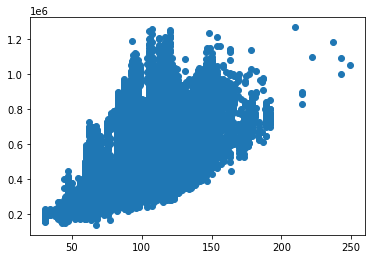

In [13]:
# floor_area_sqm vs resale_price

import matplotlib.pyplot as plt

x_p = data_ori['floor_area_sqm']
y_p = data_ori["resale_price"]

plt.scatter(x_p, y_p)
plt.show()

In [14]:
def poly_data(power):
    data = data_ori.copy()
    temp_fas = data['floor_area_sqm']
    data = data.drop('floor_area_sqm',axis=1)
    
    for i in range(power):
        data['FAS:' + str(i+1)] = np.power(temp_fas, i+1)
        
    return data

In [15]:
# Try the function built above

x = poly_data(3)
x.head()

,month,flat_type,block,street_name,storey_range,flat_model,remaining_lease,resale_price,FAS:1,FAS:2,FAS:3
0,2017-01,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,Improved,61 years 04 months,232000.0,44.0,1936.0,85184.0
1,2017-01,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,New Generation,60 years 07 months,250000.0,67.0,4489.0,300763.0
2,2017-01,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,New Generation,62 years 05 months,262000.0,67.0,4489.0,300763.0
3,2017-01,3 ROOM,465,ANG MO KIO AVE 10,04 TO 06,New Generation,62 years 01 month,265000.0,68.0,4624.0,314432.0
4,2017-01,3 ROOM,601,ANG MO KIO AVE 5,01 TO 03,New Generation,62 years 05 months,265000.0,67.0,4489.0,300763.0


In [16]:
loop = [2,3,4,5,6,7]

for i in loop:

    data = poly_data(i)

    # Sort Ordinal and OneHot Encoding

    fil_col = data.columns.tolist()

    Enco_ordinal = enc_ord(fil_col)
    Enco_OneHot = enc_One(fil_col)

    # Create a pipeline to perform Encoding use

    pipeline = ColumnTransformer([("o", OrdinalEncoder(), Enco_ordinal),
                                  ("n", OneHotEncoder(), Enco_OneHot),], remainder='passthrough')

    # Set X and y for later prediction use

    X_p = pipeline.fit_transform(data.drop("resale_price", axis=1))
    y_p = data["resale_price"].values

    # Import train_test_split function
    from sklearn.model_selection import train_test_split

    # Split dataset into training set and test set
    X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(X_p, y_p, test_size=0.3,random_state=1)
    
    polynomial_regressor = LinearRegression()#(normalize=normalize)
    polynomial_regressor.fit(X_train_p, y_train_p)

    yhat = polynomial_regressor.predict(X_test_p)

    mae = metrics.mean_absolute_error(y_test_p, yhat)
    mse = metrics.mean_squared_error(y_test_p, yhat)
    rmse = np.sqrt(mse)  
    r2 = metrics.r2_score(y_test_p,yhat)
    Adj_r2 = 1 - (1-r2) * (len(y)-1)/(len(y)-X.shape[1]-1)

    print("Number of power:" , i)
    #print("Results of sklearn.metrics:")
    print("MAE:",round(mae,4))
    print("MSE:", round(mse,4))
    print("RMSE:", round(rmse,4))
    print("R-Squared:", round(r2,4))
    print("Adjusted R-Squared:", round(Adj_r2,4))
    print()

LinearRegression()

Number of power: 2
MAE: 34508.7077
MSE: 2133042578.7158
RMSE: 46184.8739
R-Squared: 0.9127
Adjusted R-Squared: 0.9093



LinearRegression()

Number of power: 3
MAE: 86741.2956
MSE: 14478103265.1573
RMSE: 120324.9902
R-Squared: 0.4072
Adjusted R-Squared: 0.3846



LinearRegression()

Number of power: 4
MAE: 88785.8168
MSE: 15088524253.044
RMSE: 122835.3542
R-Squared: 0.3822
Adjusted R-Squared: 0.3586



LinearRegression()

Number of power: 5
MAE: 90399.612
MSE: 15793802804.6284
RMSE: 125673.3974
R-Squared: 0.3534
Adjusted R-Squared: 0.3287



LinearRegression()

Number of power: 6
MAE: 92765.6197
MSE: 16970431067.4695
RMSE: 130270.6071
R-Squared: 0.3052
Adjusted R-Squared: 0.2786



LinearRegression()

Number of power: 7
MAE: 95659.9663
MSE: 18367664986.4468
RMSE: 135527.3588
R-Squared: 0.248
Adjusted R-Squared: 0.2193



------------------------------------------------------------------------------

Comments: Degree 2 produces the best rusult

------------------------------------------------------------------------------

# Croos Validation - Polynomial Regression

In [17]:
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score, LeaveOneOut,\
RepeatedKFold, train_test_split

def cv(model,fil_col,n_splits):
    
    # Create a data copy

    data_cv = poly_data(2)
    
    # Prepare Encoding and Normalizing

    Enco_ordinal = enc_ord(fil_col)
    Enco_OneHot = enc_One(fil_col)
    num_cols = data_cv.select_dtypes('float64','int64').columns.tolist()
    num_cols.remove('resale_price')

    ct = ColumnTransformer([("o", OrdinalEncoder(), Enco_ordinal),
                            ("n", OneHotEncoder(handle_unknown = 'ignore'), Enco_OneHot)])
                        
    pipe = Pipeline([
        ('ct_step' , ct),
        ('model', model)])
    
    # Name X and y

    X = data_cv.drop(['resale_price'], axis=1)
    y = data_cv['resale_price']
    
    # Perform K-Fold

    kf = KFold(n_splits=n_splits ,shuffle = True, random_state=1)

    scores_kf = []
    i = 1
    for train_set, test_set in kf.split(X, y):
        pipe.fit(X.loc[train_set], y[train_set])
        sco = pipe.score(X.loc[test_set], y[test_set])
        scores_kf.append(sco)
        print("iteration ", i)
        i += 1

    return(np.mean(scores_kf))

# Check Results

cv_poly = cv(model = LinearRegression(),
            fil_col = ['month', 'flat_type', 'block', 'street_name', 'storey_range', 
                      'floor_area_sqm', 'flat_model', 'remaining_lease', 'resale_price'] ,
            n_splits = 5)

print('Cross Validation Result:' , cv_poly)

iteration  1
iteration  2
iteration  3
iteration  4
iteration  5
Cross Validation Result: 0.9329818215579063


In [18]:
print('Intercept:' , polynomial_regressor.intercept_)

for i in list(polynomial_regressor.coef_):
    print('fil_col:' , i)

Intercept: 374150.9044257503
fil_col: 6.142892861196082e-19
fil_col: 1.8128741921548618e-19
fil_col: 3.589565667001841e-19
fil_col: -2.874277980827286e-22
fil_col: 6.971932473720739e-23
fil_col: -1.8544717084458158e-22
fil_col: -1.7059868377714463e-22
fil_col: 4.1808932332945246e-23
fil_col: -5.500043897994057e-24
fil_col: -1.821376477803448e-24
fil_col: -7.909331239621474e-24
fil_col: -1.1727596990914977e-22
fil_col: -5.593236899151429e-24
fil_col: -5.505577338892378e-24
fil_col: -9.219456775498623e-24
fil_col: -1.2465597130767773e-23
fil_col: 1.3116682230469282e-22
fil_col: 4.9820773611966925e-23
fil_col: 3.8204553799694096e-23
fil_col: -9.901007291584879e-24
fil_col: -1.2391601118225071e-23
fil_col: 7.759668237751072e-23
fil_col: 7.373316830633501e-23
fil_col: -2.263659756862527e-22
fil_col: -9.47199774168808e-24
fil_col: -4.434985641223353e-24
fil_col: -7.690573181525057e-24
fil_col: -6.993579969736474e-24
fil_col: 6.046002362101892e-23
fil_col: 1.422447921894249e-23
fil_col: 4.095

fil_col: -8.740619872954957e-23
fil_col: -1.0049477857544249e-22
fil_col: 1.3774874600823932e-23
fil_col: 1.0292820188429572e-23
fil_col: 2.249064497684518e-23
fil_col: 1.56809417271459e-23
fil_col: -6.853039160596786e-23
fil_col: -2.1763235696792617e-24
fil_col: 6.018829153146446e-24
fil_col: 1.8575269577472674e-23
fil_col: 6.4579982389398986e-24
fil_col: -9.596865457448194e-23
fil_col: 1.4661412358610191e-23
fil_col: 1.2431404329635934e-23
fil_col: 1.4920231748557528e-23
fil_col: 4.298266907196142e-24
fil_col: 1.7049921514388396e-23
fil_col: -3.4320918720085655e-24
fil_col: 7.133303676084229e-23
fil_col: 4.3861600760203874e-23
fil_col: 3.83592367127255e-25
fil_col: -5.2905673182007506e-23
fil_col: 5.173020105035145e-23
fil_col: 6.345384753314953e-23
fil_col: 5.1053789629036416e-24
fil_col: -3.974704215843182e-24
fil_col: -5.796328942821213e-23
fil_col: 7.698074218907905e-23
fil_col: 6.013116209488548e-23
fil_col: 6.802765471018216e-23
fil_col: -6.303094291791217e-23
fil_col: 5.025889

# Ridge Regrssion

In [19]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

In [20]:
# Find best parameter

# Split dataset into training set and test set

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 1)

# Prepare a range of alpha values to test

alphas = np.array([1,0.1,0.01,0.001,0.0001,0])

# Create and fit a ridge regression model, testing each alpha

model = Ridge()
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1) 
grid = GridSearchCV(estimator=model, cv=cv,param_grid=dict(alpha=alphas))
grid.fit(X,y)

# Summarize the results of the grid search

print('Best alpha:' , grid.best_estimator_.alpha)

GridSearchCV(cv=RepeatedKFold(n_repeats=3, n_splits=10, random_state=1),
             estimator=Ridge(),
             param_grid={'alpha': array([1.e+00, 1.e-01, 1.e-02, 1.e-03, 1.e-04, 0.e+00])})

Best alpha: 0.001


# Cross Validation - Ridge Regression

In [21]:
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score, LeaveOneOut,\
RepeatedKFold, train_test_split

def cv(model,fil_col,n_splits):
    
    # Create a data copy

    data_ridge = data_ori.copy()
    
    # Prepare Encoding and Normalizing

    Enco_ordinal = enc_ord(fil_col)
    Enco_OneHot = enc_One(fil_col)
    num_cols = data_ridge.select_dtypes('float64','int64').columns.tolist()
    num_cols.remove('resale_price')

    ct = ColumnTransformer([("o", OrdinalEncoder(), Enco_ordinal),
                            ("n", OneHotEncoder(handle_unknown = 'ignore'), Enco_OneHot)])
                        
    pipe = Pipeline([
        ('ct_step' , ct),
        ('model', model)])
    
    # Name X and y

    X = data_ridge.drop(['resale_price'], axis=1)
    y = data_ridge['resale_price']
    
    # Perform K-Fold

    kf = KFold(n_splits=n_splits ,shuffle = True, random_state=1)

    scores_kf = []
    i = 1
    for train_set, test_set in kf.split(X, y):
        pipe.fit(X.loc[train_set], y[train_set])
        sco = pipe.score(X.loc[test_set], y[test_set])
        scores_kf.append(sco)
        print("iteration ", i)
        i += 1

    return(np.mean(scores_kf))


cv_ridge = cv(model = Ridge(),
             fil_col = ['month', 'flat_type', 'block', 'street_name', 'storey_range', 
                      'floor_area_sqm', 'flat_model', 'remaining_lease', 'resale_price'] ,
             n_splits = 5)

print('Cross Validation Result:' , cv_ridge)

iteration  1
iteration  2
iteration  3
iteration  4
iteration  5
Cross Validation Result: 0.9256563280737768


# Correlation Check for Numerical Columns

In [22]:
# Create a datafram that only contains numberical columns

data_copy = data_ori[['floor_area_sqm','lease_commence_date']]
data_copy.corr()

KeyError: "['lease_commence_date'] not in index"

# Chi2 Test for Categorical Columns

In [ ]:
chi2_want = Chi2_allBT_Wanted(data_ori)
chi2_unwant = Chi2_allBT_Unwanted(data_ori)

print('Dependent:',chi2_want)
print()
print('Independent', chi2_unwant)